In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Orders dispatching algorithm

The goal is to propose the most optimal order for a taxi drivers in big city (of course, if there are many orders simultaneously) considering multiple factors. It is called the **taxi dispatching problem**. 

#### General ideas

Let's describe main steps of our approach:

- General solution ideas
- EDA: find and filter out outliers and duplicates in our dataset if any, create additional fields
- Explore kernel density estimation algorithm to calculate demand degree for every order in our dataset, visualise estimated demand on map
- Building offline model (random forest) to predict demand for every new order based on demand for the last month
- Building online model (demand estimator) to predict demand for every new order based on demand for the last hour
- Description of ranking approach for orders based on demand degree
- Few words about productionisation
- Next steps to improve our models and what additional data may be useful for this

General ideas: 

Let's suppose there are several orders for single driver. Our goal is to decide what order he have to assign to him. It's reasonable that factors below must increase chance to take order:
- High demand in start point: passangers don't have to wait too long, because it's important to save loyalty 
- High `ride_price`: taking orders with higher price increase profit
- High demand in end point: after finishing current order, driver will be located in area with high demand, so he can immediately take next order without idling. Or he will haven't to spent a lot of time to get to the next order.
- Distance to the order. If all factors above are equal, it's reasonable to take the nearest order

In this task `ride_price` is given for every order. To take into account demand factors, we have to construct a method how to estimate it. When these values are calculated, we can assign a **rank** for each factor using [ordinal ranking](https://en.wikipedia.org/wiki/Ranking#Ordinal_ranking_(%221234%22_ranking)) and unite these ranks into single rank value - **final rank**. Finally, we assign the order with highest final rank to driver. Unfortunately, we don't have any information about driver's initial position so it isn't possible to take into account last factor (distance to the order). But it seems not so difficult to get this parameter in real systems.

To make demand estimation more reliable, we can build **two models** to estimate it:

- First of all, we estimate a demand for orders for every day and hour in historical data using **kernel density estimation**  [https://scikit-learn.org/stable/modules/density.html](algorithm)


- **Offline model**: it based on random forest algorithm and fits on this dataset with demand as a target using 1 month retro. Model can be saved in pickle file and predicts values `demand_offline_start` and `demand_offline_end` - demand for start and end order points.


- **Online model**: we use kernel density estimation approach for last hour data. It allows to take into account unpredictable events in the city, for example, failure in public transport, public events with crouds of people, weather anomalies. Such kind of events can dramatically change demand patterns so they can't be predicted properly by offline model. As a result, this model calculates `demand_online_start` and `demand_online_end` values for new orders.

Finally, we have 5 parameters: 
- `ride_price`
- `demand_online_start` 
- `demand_online_end`
- `demand_offline_start` 
- `demand_offline_end`

We assign rank for each of them, got a final rank and return an order with highest final rank as a result

Estimate demand in order start point, in order end point by offline and online models. 

#### Imports and constants

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import NotFittedError

In [7]:
DATA_FILE = "robotex4.csv"

RF_MODEL_PARAMS = {'n_estimators': 100, 'max_depth': 20, 'n_jobs': 8, 'random_state': 1}
RF_MODEL_FEATURES = ['start_lat','start_lng','week_day','hour', 'minute']
RF_MODEL_TARGET = 'demand'
RF_MODEL_SPLIT_DATE = '2022-03-20'
RF_MODEL_FILE = "rf_model.pkl"

DEMAND_ESTIMATOR_BANDWIDTH = 0.003
DEMAND_ESTIMATOR_KERNEL = 'epanechnikov'

CURRENT_TS_STR = "2022-03-21 15:30:00"
ORDERS_COUNT_FOR_RANKING = 100
HOURS_TO_ESTIMATE_ONLINE_DEMAND = 1
DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S"

### EDA

#### Read data

In [8]:
df = pd.read_csv(DATA_FILE)

In [9]:
df

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-11 03:20:51.446343000,59.435092,24.746192,59.413620,24.669301,1.221750
1,2022-03-21 18:51:11.394013000,59.440585,24.704871,59.448580,24.695094,0.260000
2,2022-03-23 06:44:57.844104000,59.424660,24.736591,59.414483,24.816408,1.142750
3,2022-03-26 14:42:25.716000000,59.424239,24.724754,59.401068,24.644707,1.280845
4,2022-03-09 08:10:41.153870000,59.436079,24.732235,59.397603,24.680948,1.283000
...,...,...,...,...,...,...
660216,2022-03-25 12:39:59.295086000,59.417072,24.799048,59.405560,24.706132,1.328000
660217,2022-03-03 13:45:37.653168000,59.440089,24.729332,59.434221,24.823899,1.322000
660218,2022-03-04 12:02:42.630196000,59.370844,24.668771,59.406154,24.704330,1.097000
660219,2022-03-04 07:27:50.955369000,59.489902,24.933111,59.400403,24.825276,2.899250


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660221 entries, 0 to 660220
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  660221 non-null  object 
 1   start_lat   660221 non-null  float64
 2   start_lng   660221 non-null  float64
 3   end_lat     660221 non-null  float64
 4   end_lng     660221 non-null  float64
 5   ride_value  660221 non-null  float64
dtypes: float64(5), object(1)
memory usage: 30.2+ MB


#### Check and drop duplicates if any

In [11]:
df[df.duplicated()].shape

(5095, 6)

Duplicates are present, so let's drop them

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(655126, 6)

#### Add order day and hour, calculate ride distance

Let's convert order time to datetime format, extract fields:

- `date` for train/test split in offline model,
- `week_day`, `hour`,`minute` features for offline model
- `distance` - distance between start and end order points. To simplify process let's just calculate it as a manhattan distance between theese two points.

In [14]:
df['start_time_dt'] = pd.to_datetime(df.start_time)
df['date'] = df.start_time_dt.dt.date.astype(str)
df['week_day'] = df['start_time_dt'].dt.dayofweek
df['hour'] = df['start_time_dt'].dt.hour
df['minute'] = df['start_time_dt'].dt.minute
df['distance'] = abs(df['start_lat'] - df['end_lat']) + abs(df['start_lng'] - df['end_lng'])

In [15]:
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_time_dt,date,week_day,hour,minute,distance
0,2022-03-11 03:20:51.446343000,59.435092,24.746192,59.413620,24.669301,1.221750,2022-03-11 03:20:51.446343,2022-03-11,4,3,20,0.098362
1,2022-03-21 18:51:11.394013000,59.440585,24.704871,59.448580,24.695094,0.260000,2022-03-21 18:51:11.394013,2022-03-21,0,18,51,0.017772
2,2022-03-23 06:44:57.844104000,59.424660,24.736591,59.414483,24.816408,1.142750,2022-03-23 06:44:57.844104,2022-03-23,2,6,44,0.089994
3,2022-03-26 14:42:25.716000000,59.424239,24.724754,59.401068,24.644707,1.280845,2022-03-26 14:42:25.716000,2022-03-26,5,14,42,0.103218
4,2022-03-09 08:10:41.153870000,59.436079,24.732235,59.397603,24.680948,1.283000,2022-03-09 08:10:41.153870,2022-03-09,2,8,10,0.089762


#### Detect outliers, cleaning

Let's see on simple statistics for our data

In [16]:
df.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value,week_day,hour,minute,distance
count,655126.000000,655126.000000,655126.000000,655126.000000,655126.000000,655126.000000,655126.000000,655126.000000,655126.000000
mean,59.428680,24.743487,59.397254,24.724335,2.274438,3.095696,12.845563,29.509073,0.155736
std,0.021760,0.056871,1.408540,1.646539,45.237690,1.940711,6.447609,17.153689,2.849060
min,59.321557,24.505199,-37.819979,-122.453962,0.107628,0.000000,0.000000,0.000000,0.000074
25%,59.418821,24.713181,59.415231,24.707921,0.545000,1.000000,8.000000,15.000000,0.038033
50%,59.432068,24.744689,59.430705,24.744337,1.059000,3.000000,14.000000,30.000000,0.076152
75%,59.439022,24.768146,59.439260,24.773914,1.712000,5.000000,18.000000,44.000000,0.127765
max,59.566998,24.973743,61.552744,144.966110,3172.701000,6.000000,23.000000,59.000000,217.470755


It's easy to see that there are anomaly values in `ride_value` field and in geo coordinates (points abnormally far away from Tallinn) and hence in `distance`  field. To drop outliers, we can calculate percentiles to decide which data we have to remove

In [17]:
dist_percentiles = np.percentile(df['distance'], range(1,101))
value_percentiles = np.percentile(df['ride_value'], range(1,101))

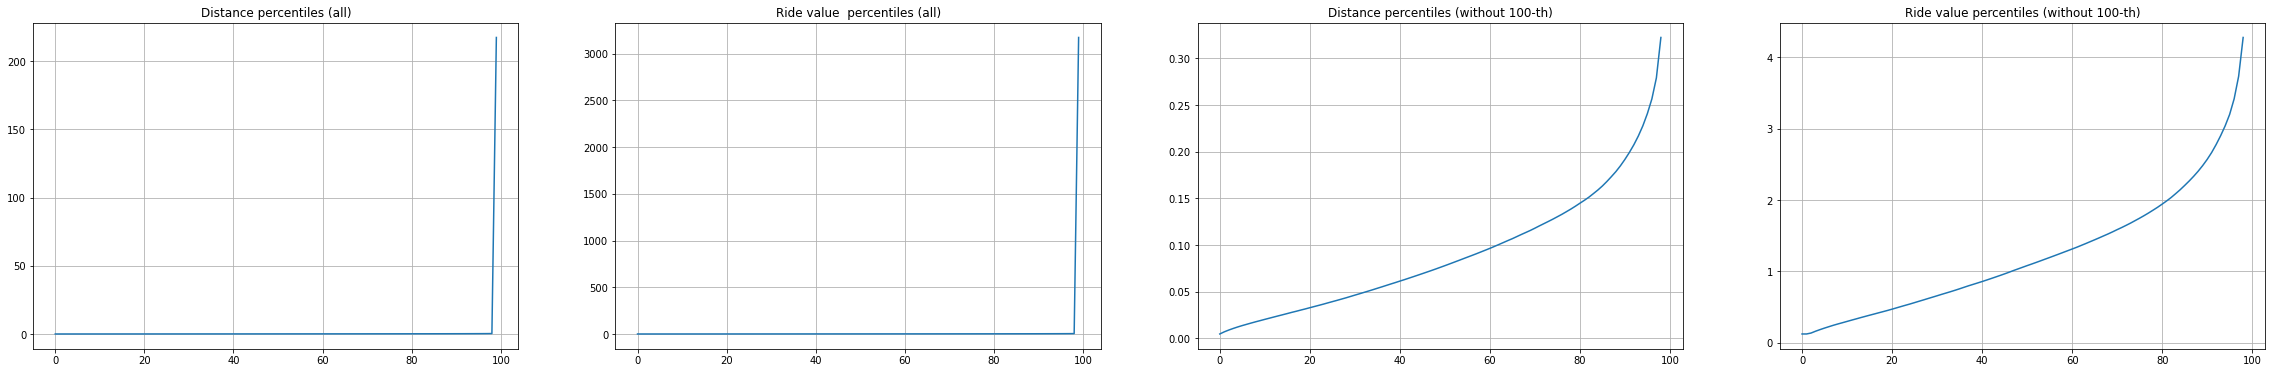

In [18]:
plt.figure(figsize=(40,6))

plt.subplot(1, 4, 1)
plt.plot(dist_percentiles)
plt.grid()
plt.title("Distance percentiles (all)")

plt.subplot(1, 4, 2)
plt.plot(value_percentiles)
plt.grid()
plt.title("Ride value  percentiles (all)")

# Plot all percentiles but last
plt.subplot(1, 4, 3)
plt.plot(dist_percentiles[:99])
plt.grid()
plt.title("Distance percentiles (without 100-th)")

plt.subplot(1, 4, 4)
plt.plot(value_percentiles[:99])
plt.grid()
plt.title("Ride value percentiles (without 100-th)");

In [19]:
df.shape

(655126, 12)

So it's better to remove last persentiles

In [20]:
df = df.loc[(df['ride_value'] <= value_percentiles[98]) & (df['distance'] <= dist_percentiles[98])]

In [21]:
df.shape

(647578, 12)

In [22]:
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_time_dt,date,week_day,hour,minute,distance
0,2022-03-11 03:20:51.446343000,59.435092,24.746192,59.413620,24.669301,1.221750,2022-03-11 03:20:51.446343,2022-03-11,4,3,20,0.098362
1,2022-03-21 18:51:11.394013000,59.440585,24.704871,59.448580,24.695094,0.260000,2022-03-21 18:51:11.394013,2022-03-21,0,18,51,0.017772
2,2022-03-23 06:44:57.844104000,59.424660,24.736591,59.414483,24.816408,1.142750,2022-03-23 06:44:57.844104,2022-03-23,2,6,44,0.089994
3,2022-03-26 14:42:25.716000000,59.424239,24.724754,59.401068,24.644707,1.280845,2022-03-26 14:42:25.716000,2022-03-26,5,14,42,0.103218
4,2022-03-09 08:10:41.153870000,59.436079,24.732235,59.397603,24.680948,1.283000,2022-03-09 08:10:41.153870,2022-03-09,2,8,10,0.089762


Let's visualize histograms for `distance` and `ride_value` to make sure they don't have outliers now

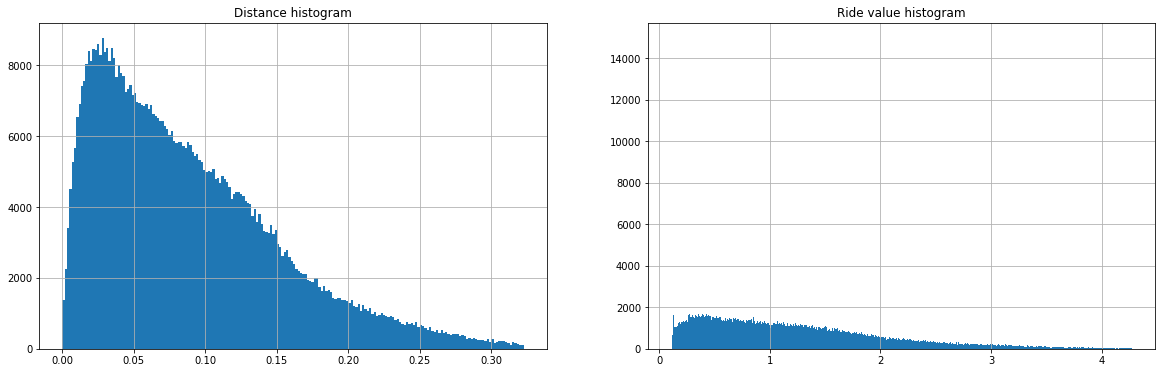

In [89]:
plt.figure(figsize=(30,6))
plt.subplot(1, 2, 1)  
df.distance.hist(bins=200)
plt.title("Distance histogram");

plt.subplot(1, 2, 2) 
df.ride_value.hist(bins=1000)
plt.title("Ride value histogram");

### Offline demand estimation

The simplest way to estimate demand for every point on map is **kernel density estimation** that ensures the smoothness of the resulting orders distribution. To reduce time complexity of such demand estimation approach we'll use **finite kernel**, for example, **Epanechnikov's kernel**. To achieve a proper demand estimation we have to fit `bandwidth` parameter. 


To make sure this approach is reliable, let's check orders regularity. We suppose, that there are not any "outliers" (no orders or too big orders count) and there were enough orders during each hour in dataset.

#### Check orders regularity

In [24]:
orders_count_df = df.groupby(['date', 'hour']).size().reset_index().rename(columns={0:'orders_count'})

In [25]:
orders_count_df.orders_count.min()

279

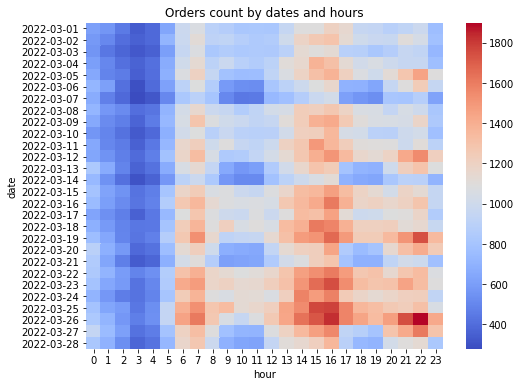

In [90]:
plt.figure(figsize=(8,6))
sns.heatmap(
    orders_count_df.pivot_table(index='date', columns='hour', values='orders_count'), 
    cmap=sns.color_palette("coolwarm", as_cmap=True) 
)
plt.title("Orders count by dates and hours");

So we see, there aren't any anomalies in orders distribution, moreover, there are some patterns by days and hours

#### Calculate demand as an orders' density 

Let's write own `DemandEstimator` class based on `KernelDensity` class for convenience.

In [29]:
class DemandEstimator:
    
    def __init__(self, bandwidth=DEMAND_ESTIMATOR_BANDWIDTH, kernel=DEMAND_ESTIMATOR_KERNEL):
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.estiamtor = None
        self.is_fitted = False
        
    def fit(self, x):
        
        points = x[['start_lng', 'start_lat']].values 
        kde = KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel)  
        kde.fit(points)
        
        self.estiamtor = kde
        self.is_fitted = True
        
        return self
        
    def transform(self, x):
        
        if not self.is_fitted:
            raise NotFittedError("Estimator not fitted")
            
        points = x[['start_lng', 'start_lat']].values        
        demand = self.estiamtor.score_samples(points)
        
        result_df = pd.DataFrame({'demand': demand})
        result_df.index = x.index
    
        return result_df
    

Calculate `demand` values for all orders in dataset

In [30]:
%%time
demand_df = df.groupby(['date', 'hour'], group_keys=False).apply(lambda x: DemandEstimator().fit(x).transform(x))

CPU times: user 5.59 s, sys: 12 ms, total: 5.6 s
Wall time: 5.62 s


In [31]:
df = df.join(demand_df)

Let's visualize `demand` values (together and for dates and hours given) to make sure these values properly describes real demand in the city 

In [32]:
def plot_start_points_with_demand(df):
    
    plt.scatter(
        x=df.start_lng, 
        y=df.start_lat, 
        c=df.demand,
        cmap=sns.color_palette("coolwarm", as_cmap=True), 
        alpha=0.6,
        s=10
    )
    
    plt.colorbar(label="Demand")
    plt.title("Start points and demand")
    plt.grid()

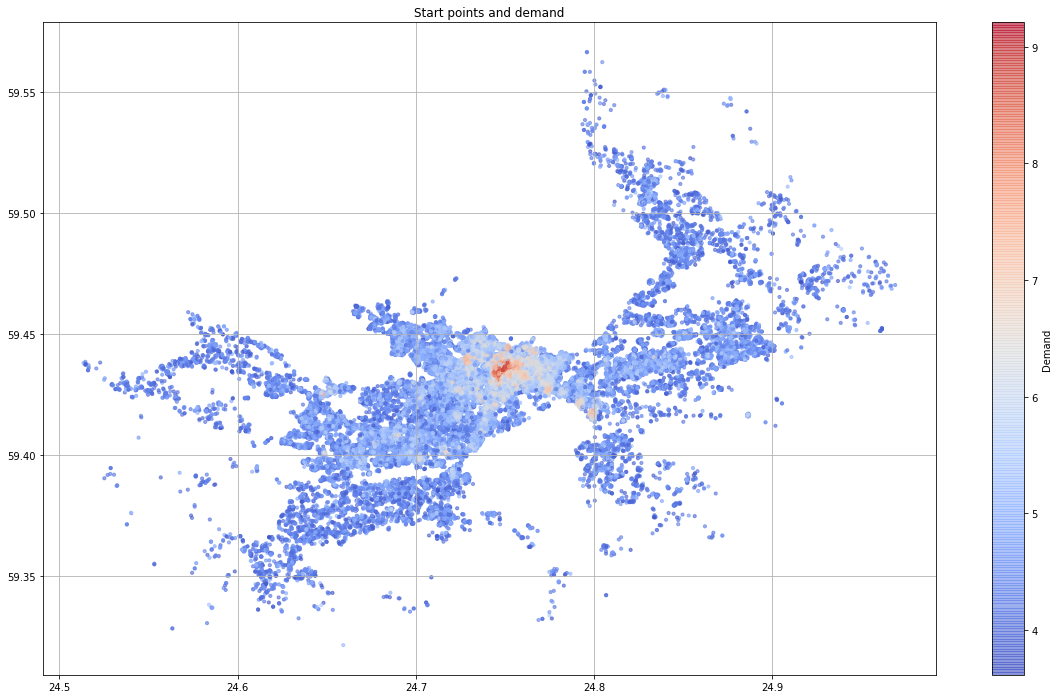

In [33]:
plt.figure(figsize=(20,12))
plot_start_points_with_demand(df.head(100000))

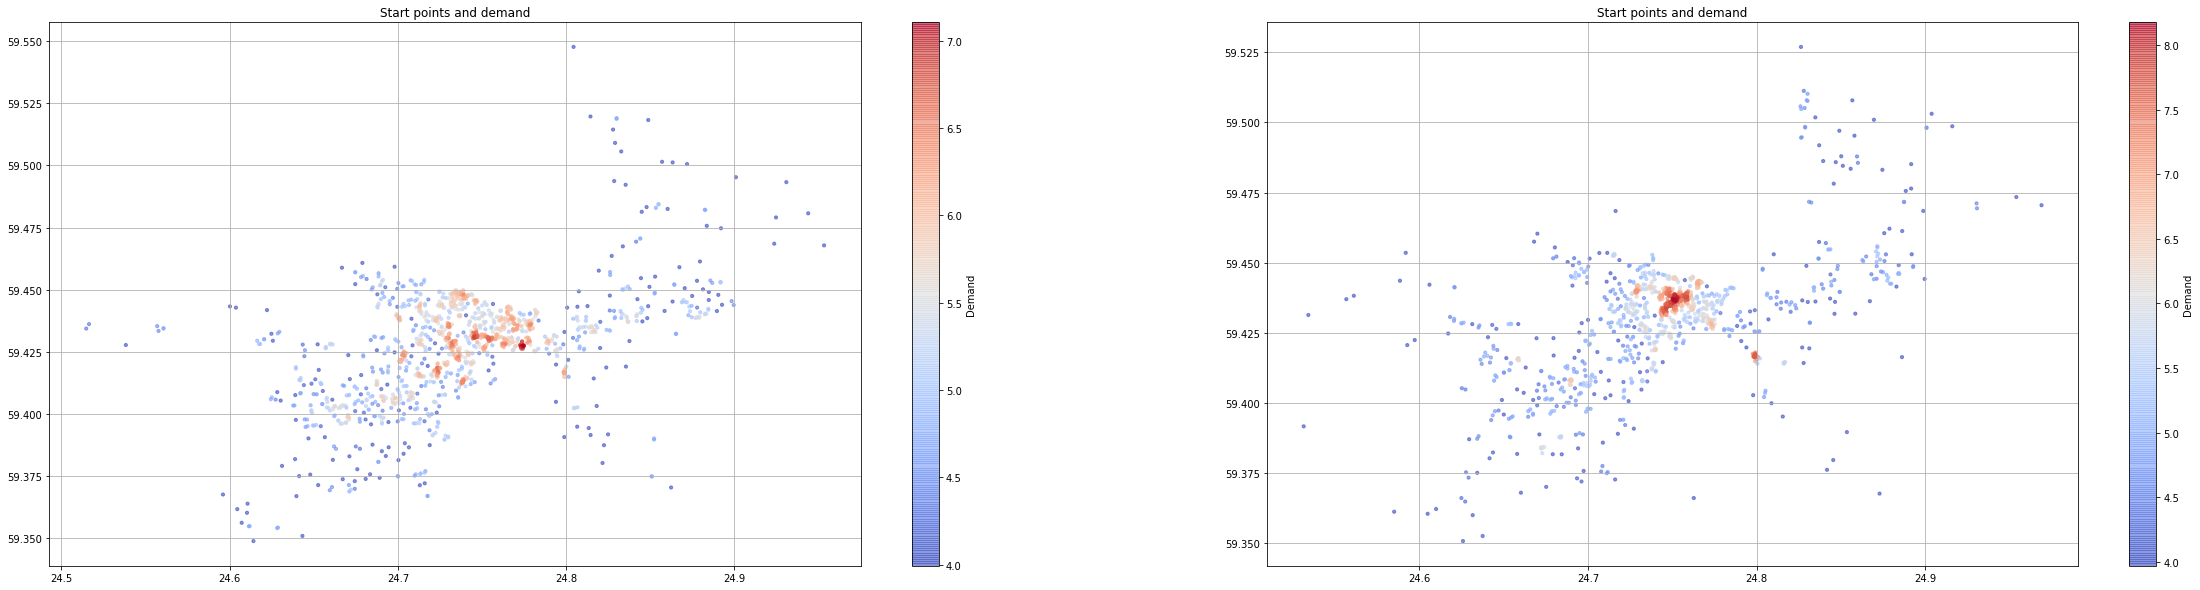

In [34]:
plt.figure(figsize=(40,10))

plt.subplot(1, 2, 1) 
plot_start_points_with_demand(df[(df['date'] == '2022-03-22') & (df['hour'] == 6)])

plt.subplot(1, 2, 2) 
plot_start_points_with_demand(df[(df['date'] == '2022-03-22') & (df['hour'] == 22)])

It's easy to see, that at **morning hours** areas with high demand located at outskirts - people ride from home to offices, while at **evening and night hours** high demand located in the city centre, because they ride backward.  

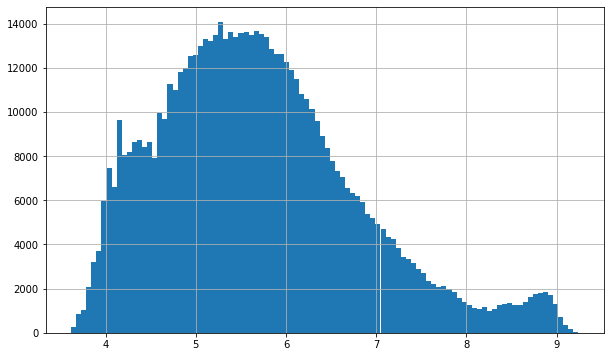

In [35]:
plt.figure(figsize=(10,6))
df.demand.hist(bins=100);

#### Demand prediction model

Let's build **offline model** to predict demand for current hour, weekday and geo coordinates 

In [42]:
model_df = df[RF_MODEL_FEATURES + [RF_MODEL_TARGET, 'date']].copy()

train = model_df[model_df['date'] < RF_MODEL_SPLIT_DATE]
test = model_df[model_df['date'] >= RF_MODEL_SPLIT_DATE]

X_train = train[RF_MODEL_FEATURES]
y_train = train[RF_MODEL_TARGET]

X_test = test[RF_MODEL_FEATURES]
y_test = test[RF_MODEL_TARGET]

In [47]:
X_train.shape, X_test.shape

((419498, 5), (228080, 5))

In [51]:
%%time
rf_model = RandomForestRegressor(**RF_MODEL_PARAMS)
rf_model.fit(X_train, y_train)

CPU times: user 4min 51s, sys: 972 ms, total: 4min 52s
Wall time: 39.1 s


RandomForestRegressor(max_depth=20, n_jobs=8, random_state=1)

In [54]:
with open(RF_MODEL_FILE, 'wb') as f:
    pickle.dump(rf_model, f)

In [55]:
with open(RF_MODEL_FILE, 'rb') as f:
    rf_model = pickle.load(f)

In [94]:
! ls -lh | grep rf_model.pkl

-rw-r--r-- 1 user user 911M Jun 10 17:51 rf_model.pkl


Feature importances

In [57]:
dict(zip(RF_MODEL_FEATURES, rf_model.feature_importances_))

{'start_lat': 0.21631609174844715,
 'start_lng': 0.5952500800890137,
 'week_day': 0.015859171069422088,
 'hour': 0.1618718308014675,
 'minute': 0.010702826291649528}

In [58]:
%%time
y_train_prediction = rf_model.predict(X_train)
y_test_prediction = rf_model.predict(X_test)

CPU times: user 48.8 s, sys: 91.7 ms, total: 48.9 s
Wall time: 6.64 s


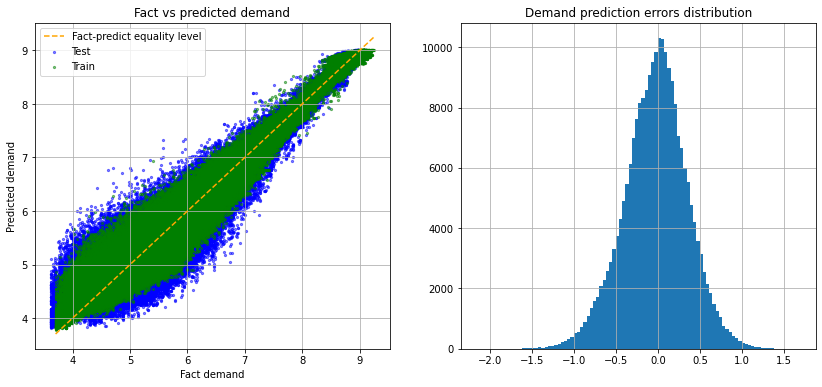

In [66]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)  
plt.scatter(y_test, y_test_prediction, alpha=0.5, s=5, c='b', label="Test")
plt.scatter(y_train, y_train_prediction, alpha=0.5, s=5, c='g', label="Train")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='orange', linestyle='dashed', label="Fact-predict equality level");
plt.xlabel("Fact demand")
plt.ylabel("Predicted demand")
plt.title("Fact vs predicted demand")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
(y_test - y_test_prediction).hist(bins=100)
plt.title("Demand prediction errors distribution");

It isn't so important to train our random forest perfectly now but we see, that it works pretty well. But serialized model is quite big (911 Mb) so it should to regularize it more precisely to reduce its size without loose of performance

### Online demand estimation and orders ranking

All previous steps can be done in offline mode: for example, every day we can preprocess new data, retrain random forest model and serialize it.

Now suppose that we received several orders (in our example 100) at `CURRENT_TS_STR` time. We have to perform the following operations:

- Make predictions for `demand_offline_start` and `demand_offline_end` by offline model
- Select orders data for last short time period (in our example 1 hour), fit our `DemandEstimator` using them and calculate `demand_online_start`, `demand_online_end`
- Calculate **ranks** and **final_rank**, return order with the highest rank as a result


In [96]:
CURRENT_TS_STR

'2022-03-21 15:30:00'

Take first 100 morning orders later than "split_date" and rank them

#### Make estimations (offline and online) for demand in start and end points 

In [83]:
def estimate_demand(df, rf_model, current_ts_str, hours_to_estimate=HOURS_TO_ESTIMATE_ONLINE_DEMAND, orders_cnt=ORDERS_COUNT_FOR_RANKING):
    
    current_ts = datetime.strptime(current_ts_str, DATETIME_FORMAT)
    demand_evaluation_start_ts = current_ts - timedelta(hours=hours_to_estimate)
    demand_evaluation_df = df[df['start_time_dt'].between(demand_evaluation_start_ts, current_ts)].sort_values(by='start_time_dt').copy()
    demand_evaluation_df = demand_evaluation_df[['hour', 'start_lng', 'start_lat']].copy()
    
    de = DemandEstimator()
    de.fit(demand_evaluation_df)
    
    control_df = df[(df['start_time_dt'] > current_ts)].sort_values(by='start_time_dt').head(orders_cnt)
    demand_online_start_df = de.transform(control_df[['start_lng', 'start_lat']]).rename(columns={'demand':'demand_online_start'})
    demand_online_start_df.loc[demand_online_start_df['demand_online_start'] < 0, 'demand_online_start'] = 1
    
    demand_online_end_df = de.transform(
        control_df[['hour', 'end_lng', 'end_lat']].rename(
            columns={
                     'end_lng':'start_lng', 
                     'end_lat':'start_lat'
                    }
        )
    ).rename(columns={'demand':'demand_online_end'})
    demand_online_end_df.loc[demand_online_end_df['demand_online_end'] < 0, 'demand_online_end'] = 1
    
    demand_offline_start_array = rf_model.predict(control_df[['start_lat', 'start_lng', 'week_day', 'hour', 'minute']])
    demand_offline_end_array = rf_model.predict(control_df[['end_lat', 'end_lng', 'week_day', 'hour', 'minute']])
    demand_offline_df = pd.DataFrame({'demand_offline_start':demand_offline_start_array, 'demand_offline_end': demand_offline_end_array})
    demand_offline_df.index = control_df.index
    
    control_df = control_df.join(demand_online_start_df)
    control_df = control_df.join(demand_online_end_df)   
    control_df['demand_offline_start'] = demand_offline_df['demand_offline_start']
    control_df['demand_offline_end'] = demand_offline_df['demand_offline_end']
    
    return control_df
    
    

In [84]:
%%time
demand_df = estimate_demand(df, rf_model, CURRENT_TS_STR)

CPU times: user 219 ms, sys: 8.09 ms, total: 227 ms
Wall time: 201 ms


In [85]:
demand_df

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_time_dt,date,week_day,hour,minute,distance,demand,demand_online_start,demand_online_end,demand_offline_start,demand_offline_end
66795,2022-03-21 15:30:00.018250000,59.443523,24.726589,59.415900,24.739412,0.786750,2022-03-21 15:30:00.018250,2022-03-21,0,15,30,0.040446,4.773883,5.082574,5.396837,5.142348,5.608619
415640,2022-03-21 15:30:01.503524000,59.491927,24.856823,59.414340,24.816506,2.224500,2022-03-21 15:30:01.503524,2022-03-21,0,15,30,0.117903,4.623785,1.000000,1.000000,4.292863,5.072933
27476,2022-03-21 15:30:02.262900000,59.355978,24.630900,59.437724,24.763355,2.919500,2022-03-21 15:30:02.262900,2022-03-21,0,15,30,0.214202,4.056007,3.373556,6.547663,4.452519,6.283302
204278,2022-03-21 15:30:07.513580000,59.442023,24.827405,59.378026,24.711120,2.399250,2022-03-21 15:30:07.513580,2022-03-21,0,15,30,0.180282,4.698019,1.231572,3.820654,4.776386,4.780823
303884,2022-03-21 15:30:11.155000000,59.432395,24.759626,59.434013,24.711329,0.680664,2022-03-21 15:30:11.155000,2022-03-21,0,15,30,0.049915,6.727909,6.797466,1.000000,6.862397,4.960016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562005,2022-03-21 15:34:08.769983000,59.430592,24.737360,59.426933,24.724307,0.207500,2022-03-21 15:34:08.769983,2022-03-21,0,15,34,0.016712,5.681350,5.223226,6.624834,5.534117,6.529809
490977,2022-03-21 15:34:12.158994000,59.441337,24.733568,59.435814,24.827749,1.315500,2022-03-21 15:34:12.158994,2022-03-21,0,15,34,0.099705,5.961694,5.276879,5.188231,5.768469,5.107810
626452,2022-03-21 15:34:16.694899000,59.436821,24.780449,59.446815,24.737225,0.660750,2022-03-21 15:34:16.694899,2022-03-21,0,15,34,0.053218,5.381498,4.534299,4.805620,5.379412,5.335354
174575,2022-03-21 15:34:18.475908000,59.376147,24.715756,59.436660,24.750278,1.746000,2022-03-21 15:34:18.475908,2022-03-21,0,15,34,0.095035,4.240191,1.000000,6.309140,4.743097,6.391730


Let's compare how offline and online models perform on start and end points

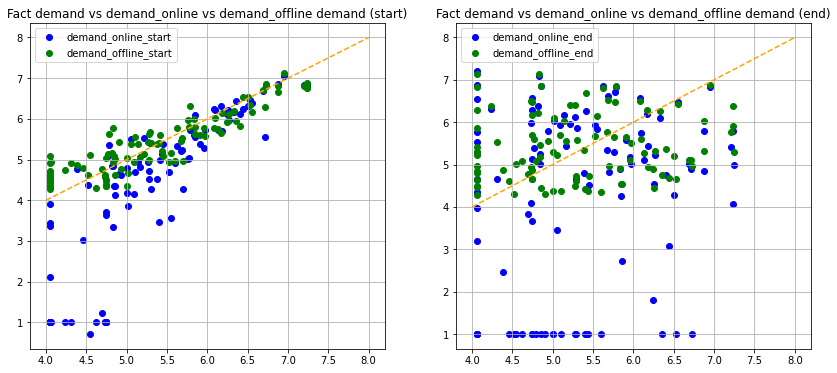

In [75]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1) 

plt.scatter(demand_df['demand'], demand_df['demand_online_start'],  c='b', label='demand_online_start')
plt.scatter(demand_df['demand'], demand_df['demand_offline_start'],  c='g', label='demand_offline_start')
plt.plot([4, 8], [4, 8], c='orange', linestyle='dashed');
plt.title("Fact demand vs demand_online vs demand_offline demand (start)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2) 

plt.scatter(demand_df['demand'], demand_df['demand_online_end'],  c='b', label='demand_online_end')
plt.scatter(demand_df['demand'], demand_df['demand_offline_end'],  c='g', label='demand_offline_end')
plt.plot([4, 8], [4, 8], c='orange', linestyle='dashed');
plt.title("Fact demand vs demand_online vs demand_offline demand (end)")
plt.legend()
plt.grid()

Easy to see, that online ans offline  models both are good enough on start points and fails on end points. 

#### Add ranking scores

Finally, calculate ranks and `final_rank` values

In [76]:
def calculate_rank(demand_df):
    
    rank_columns = ['demand_online_start', 'demand_offline_start', 'demand_online_end', 'demand_offline_end', 'ride_value'] 

    for rnk_col in rank_columns:
        demand_df[rnk_col + '_rnk'] = demand_df[rnk_col].rank(ascending=False)

    demand_df['final_rnk'] = demand_df[[c + '_rnk' for c in rank_columns]].sum(axis=1)

    return demand_df.sort_values(by='final_rnk', ascending=True)

In [77]:
%%time
result_df = calculate_rank(demand_df)

CPU times: user 17.1 ms, sys: 4 ms, total: 21.1 ms
Wall time: 16.7 ms


In [97]:
result_df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_time_dt,date,week_day,hour,...,demand_online_start,demand_online_end,demand_offline_start,demand_offline_end,demand_online_start_rnk,demand_offline_start_rnk,demand_online_end_rnk,demand_offline_end_rnk,ride_value_rnk,final_rnk
215650,2022-03-21 15:33:30.528000000,59.436372,24.758006,59.421241,24.744132,0.468504,2022-03-21 15:33:30.528000,2022-03-21,0,15,...,7.058031,6.836656,7.137886,6.887664,1.0,1.0,6.0,3.0,87.0,98.0
315285,2022-03-21 15:34:21.473557000,59.426855,24.655454,59.427042,24.723833,0.948750,2022-03-21 15:34:21.473557,2022-03-21,0,15,...,6.237622,6.579084,5.765529,6.502880,16.0,31.0,10.0,11.0,53.0,121.0
75977,2022-03-21 15:33:56.774800000,59.439953,24.759404,59.421262,24.744687,0.557250,2022-03-21 15:33:56.774800,2022-03-21,0,15,...,5.731637,6.822359,6.319141,6.853027,24.0,13.0,7.0,4.0,79.0,127.0
232183,2022-03-21 15:30:59.629573000,59.421580,24.792071,59.398643,24.670425,1.803750,2022-03-21 15:30:59.629573,2022-03-21,0,15,...,6.844977,4.843899,6.667279,5.316277,3.0,9.0,54.0,48.0,19.0,133.0
404703,2022-03-21 15:32:20.657109000,59.421289,24.744217,59.434802,24.745744,0.375500,2022-03-21 15:32:20.657109,2022-03-21,0,15,...,6.833494,5.802717,6.888906,6.385342,5.0,2.0,29.0,18.0,93.0,147.0


So, in online mode two functions must be called:
- `estimate_demand`
- `calculate_rank`

It's noticeable that total inference time in online mode **is less than 300ms** ! This time includes offline model inference + online model fitting and inference. It means that we can return result immediately

### Deploying

#### Deploying

There is no problem to train offline model once a day, we can set cron schedule to run this process regulary and owerwrite model pickle file.

For online model we additionally need drivers' geo coordinates that allow calculate distance from each driver to each order. For each driver we additionally calculate `distance_rank` for every order, add it to `final_rank`, perform reranking and assign an order with highest rank for every driver who is idling at this moment. It can be implemented as **Flask service**, that loads offline model during start and has API, that allows to send orders' list and returns a proper order as a result.

If there are too many drivers idling, this operation can be quite heavy. One way to solve this problem is running several service instances, each of them services separate city district. Message broker can be used to manage orders' flow.